# 使用LSTM+Multitask+MLP，对给定的小时级u,v，给出小时级power_total以及capacity_total

## 定义数据预处理相关类和函数

In [66]:
import pandas as pd
import numpy as np

path = r'E:\PKU_ThirdGrade_Autumn\机器学习基础'
u_wind = []
v_wind = []
capacity = []
power = []
sample_number = [0,1000,2000,3000,4000,5000]
for j in range(1,6):
    for i in range(sample_number[j-1],sample_number[j]):
        if i == 4014:
            continue
        u_file = path + rf'\Results_{j}\data_{i}\u.csv'
        v_file = path + rf'\Results_{j}\data_{i}\v.csv'
        capacity_file = path + rf'\Results_{j}\data_{i}\capacity.csv'
        power_file = path + rf'\Results_{j}\data_{i}\power.csv'
        df = pd.read_csv(u_file,header = None)
        u_wind.append(df.iloc[:,0].values)
        df = pd.read_csv(v_file,header = None)
        v_wind.append(df.iloc[:,0].values)
        df = pd.read_csv(power_file)
        power.append(df.iloc[2:,10].values)
        df = pd.read_csv(capacity_file)
        capacity.append(df.iloc[1:,10].values)
    
u_wind = np.array(u_wind)
v_wind = np.array(v_wind)
capacity = np.array(capacity)
power = np.array(power)
print(u_wind.shape)
print(v_wind.shape)
print(capacity.shape)
print(power.shape)

(4999, 8760)
(4999, 8760)
(4999, 12)
(4999, 8760)


In [67]:
u_wind = np.transpose(u_wind)
v_wind = np.transpose(v_wind)
capacity = np.transpose(capacity)
power = np.transpose(power)
print(u_wind.shape)
print(v_wind.shape)
print(capacity.shape)
print(power.shape)
input_size = u_wind.shape[0] 
output_capacity_size = capacity.shape[0]
output_power_size = power.shape[0]

(8760, 4999)
(8760, 4999)
(12, 4999)
(8760, 4999)


In [68]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import matplotlib.pyplot as plt

sample_number = 4999
def data_initialization(u_wind,v_wind,capacity,power):
    input_merged, target1, target2 = [], [], []
    for i in range(sample_number):
        u_wind_sample = list(u_wind[:,i])
        v_wind_sample = list(v_wind[:,i])
        capacity_sample = list(capacity[:,i])
        power_sample = list(power[:,i])
        u_wind_sample = np.array(u_wind_sample)
        v_wind_sample = np.array(v_wind_sample)
        input_sample = np.column_stack((u_wind_sample, v_wind_sample))
        input_merged.append(input_sample)
        target1.append(capacity_sample)
        target2.append(power_sample)
        
    print(np.array(input_merged).shape,np.array(target1).shape,np.array(target2).shape)
    return np.array(input_merged), np.array(target1), np.array(target2)

class dataset_to_Dataset(Dataset):
    def __init__(self,data_input_merged,data_target1,data_target2):
        self.len = data_input_merged.shape[0]
        print(data_input_merged.shape)
        print(data_target1.shape)
        print(data_target2.shape)
        self.input_merged = torch.from_numpy(data_input_merged)
        self.target1 = torch.from_numpy(data_target1)
        self.target2 = torch.from_numpy(data_target2)
        
    def __getitem__(self,index):
        return self.input_merged[index,:,:],self.target1[index,:],self.target2[index,:]
    
    def __len__(self):
        return self.len
    
def dataset_split_6sets(data_input_merged, data_target1,data_target2, ratio=0.9):
    split_index = int(ratio*sample_number)
    train_input_merged = data_input_merged[:split_index,:]
    train_target1 = data_target1[:split_index,:]
    train_target2 = data_target2[:split_index,:]
    test_input_merged = data_input_merged[split_index:,:]
    test_target1 = data_target1[split_index:,:]
    test_target2 = data_target2[split_index:,:]
    return train_input_merged, train_target1,train_target2,test_input_merged, test_target1,test_target2

## 搭建LSTM+Multitask+MLP神经网络

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim

class MultiTaskLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, seq_len, capacity_len, dropout):
        super(MultiTaskLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

        # Hourly generation resource prediction branch
        self.hourly_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
            # nn.LeakyReLU()
        )

        # Capacity prediction branch
        self.capacity_branch = nn.Sequential(
            nn.Linear( seq_len * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, capacity_len)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # LSTM output: (batch, seq_len, hidden_dim)
        # lstm_out = lstm_out[:, -1, :]
        hourly_output = self.hourly_branch(lstm_out).squeeze(-1)  # (batch,seq_len)
        
        flat_features = lstm_out.flatten(start_dim=1)  # Flatten for capacity branch
        capacity_output = self.capacity_branch(flat_features)  # (batch, capacity_len)

        return hourly_output, capacity_output


In [70]:
# Model parameters
input_dim = 2           # Two input features: wind speed u and v
hidden_dim = 32        # Hidden dimension for LSTM
num_layers = 2          # Number of LSTM layers
seq_len = output_power_size          # Length of the time series (hours in a year)
capacity_len = output_capacity_size      # Length of the wind power capacity output
dropout = 0.1           # Dropout rate

# Initialize the model
model = MultiTaskLSTMModel(input_dim, hidden_dim, num_layers, seq_len, capacity_len, 0.1)
print(model)

MultiTaskLSTMModel(
  (lstm): LSTM(2, 32, num_layers=2, batch_first=True, dropout=0.1)
  (hourly_branch): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
  (capacity_branch): Sequential(
    (0): Linear(in_features=280320, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=12, bias=True)
  )
)


## 开始训练网络

In [71]:
import time
import torch.nn as nn
import torch.optim as optim
import torch
# Example inputs
BATCH_SIZE = 64
LEARN_RATE = 1e-3

dataset_input_merged, dataset_target1,dataset_target2 = data_initialization(u_wind,v_wind, capacity, power)
print(dataset_input_merged.shape)
print(dataset_target1.shape)
print(dataset_target2.shape)
dataset_input_merged = dataset_input_merged.astype(np.float32)
dataset_target1 = dataset_target1.astype(np.float32)
dataset_target2 = dataset_target2.astype(np.float32)

train_input_merged, train_target1,train_target2,test_input_merged, test_target1,test_target2 = dataset_split_6sets(dataset_input_merged, dataset_target1,dataset_target2)
train_set = dataset_to_Dataset(train_input_merged,train_target1,train_target2)

train_set_iter = DataLoader(dataset=train_set,# 将数据封装进Dataloader类
                            batch_size=BATCH_SIZE,
                            shuffle=True,  # 打乱batch与batch之间的顺序
                            drop_last=True)# drop_last = True表示最后不够一个batch就舍弃那些多余的数据


(4999, 8760, 2) (4999, 12) (4999, 8760)
(4999, 8760, 2)
(4999, 12)
(4999, 8760)
(4499, 8760, 2)
(4499, 12)
(4499, 8760)


In [89]:
# gpu的定义

EPOCH = 200

device = ('cuda'if torch.cuda.is_available else 'cpu')
print(device)

# 网络的实例化
model = MultiTaskLSTMModel(2, 64, 2, 8760, 12, 0.1).to(device)

# 优化器的定义
optim_lstm = optim.Adam(params=model.parameters(), lr=LEARN_RATE)

# 损失函数的定义
loss_fuc = nn.MSELoss()
criterion = nn.SmoothL1Loss()

start = time.perf_counter()

BATCH_SIZE =64
loss_plot = []
for epoch in range(EPOCH):
    loss_print = []
    for batch_idx, (x, y1, y2) in enumerate(train_set_iter):
        x = x.reshape([BATCH_SIZE, input_size, 2])
        x = x.to(device)
        y1 = y1.reshape((BATCH_SIZE,capacity_len))
        y1 = y1.to(device)
        y2 = y2.reshape((BATCH_SIZE,seq_len))
        y2 = y2.to(device)
        y2_pred,y1_pred = model(x)
        loss = criterion(y1, y1_pred) + criterion(y2, y2_pred)
        loss_print.append(loss.item())
        # 三大步
        # 网络的梯度值更为0
        model.zero_grad()
        # loss反向传播
        loss.backward()
        # 优化器更新
        optim_lstm.step()
    print(f'{epoch} of loss: LSTM+Multitask+MLP:loss:',sum(loss_print)/len(loss_print))
    loss_plot.append(sum(loss_print)/len(loss_print))
        
end = time.perf_counter()
print('训练时间为：{:.2f}s'.format(end-start))

cuda
0 of loss: LSTM+Multitask+MLP:loss: 16186.635714285714
1 of loss: LSTM+Multitask+MLP:loss: 13943.278892299108
2 of loss: LSTM+Multitask+MLP:loss: 13874.797642299107
3 of loss: LSTM+Multitask+MLP:loss: 13798.204157366072
4 of loss: LSTM+Multitask+MLP:loss: 13695.148060825893
5 of loss: LSTM+Multitask+MLP:loss: 13576.3873046875
6 of loss: LSTM+Multitask+MLP:loss: 13418.56201171875
7 of loss: LSTM+Multitask+MLP:loss: 13232.240764508928
8 of loss: LSTM+Multitask+MLP:loss: 13029.147991071428
9 of loss: LSTM+Multitask+MLP:loss: 12788.564453125
10 of loss: LSTM+Multitask+MLP:loss: 12536.215011160713
11 of loss: LSTM+Multitask+MLP:loss: 12269.190792410714
12 of loss: LSTM+Multitask+MLP:loss: 11945.293540736608
13 of loss: LSTM+Multitask+MLP:loss: 11627.454380580357
14 of loss: LSTM+Multitask+MLP:loss: 11277.730008370536
15 of loss: LSTM+Multitask+MLP:loss: 10902.37876674107
16 of loss: LSTM+Multitask+MLP:loss: 10527.76353236607
17 of loss: LSTM+Multitask+MLP:loss: 10102.867201450892
18 of

In [90]:
torch.save(model.state_dict(), 'lstm_multitask_mlp_3.pt')

Text(0.5, 1.0, 'loss curve')

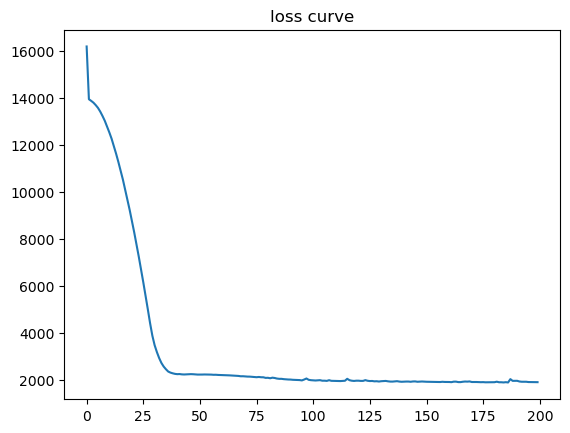

In [91]:
plt.plot(loss_plot)
plt.title("loss curve")

## 检测网络效果

In [99]:
model = MultiTaskLSTMModel(2, 64, 2, 8760, 12, 0.1).to(device)
model.load_state_dict(torch.load('lstm_multitask_mlp_3.pt'))

model.eval()

BATCH_SIZE = 1
test_set = dataset_to_Dataset(test_input_merged,test_target1,test_target2)
test_set_iter = DataLoader(dataset=test_set,batch_size=BATCH_SIZE,drop_last=True)

loss_data = []
y1_pred_data = []
y1_ref_data = []
y2_pred_data = []
y2_ref_data = []
for batch_idx, (x, y1, y2) in enumerate(test_set_iter):
    x = x.reshape([BATCH_SIZE, input_size, 2])
    x = x.to(device)
    y1 = y1.reshape((BATCH_SIZE,capacity_len))
    y1 = y1.to(device)
    y2 = y2.reshape((BATCH_SIZE,seq_len))
    y2 = y2.to(device)
    y2_pred,y1_pred = model(x)
    loss = criterion(y1, y1_pred) + criterion(y2, y2_pred)
    print(loss.item())
    loss_data.append(loss.item())
    y1_pred_data.append(y1_pred.detach().cpu().numpy())
    y2_pred_data.append(y2_pred.detach().cpu().numpy())
    y1_ref_data.append(y1.detach().cpu().numpy())
    y2_ref_data.append(y2.detach().cpu().numpy())
    print(f"{batch_idx} has been finished")    

(500, 8760, 2)
(500, 12)
(500, 8760)
1863.0828857421875
0 has been finished
2628.7314453125
1 has been finished
1819.9481201171875
2 has been finished
2009.2998046875
3 has been finished
1830.2239990234375
4 has been finished
1832.614501953125
5 has been finished
1807.3375244140625
6 has been finished
2141.588623046875
7 has been finished
1815.8277587890625
8 has been finished
1958.04248046875
9 has been finished
1819.8780517578125
10 has been finished
1803.63720703125
11 has been finished
2678.45361328125
12 has been finished
1808.7113037109375
13 has been finished
2564.5048828125
14 has been finished
1855.2606201171875
15 has been finished
1911.195556640625
16 has been finished
1807.76318359375
17 has been finished
1846.1241455078125
18 has been finished
1807.0906982421875
19 has been finished
1810.7755126953125
20 has been finished
1801.7584228515625
21 has been finished
1830.534423828125
22 has been finished
1821.676513671875
23 has been finished
1804.5029296875
24 has been finishe

[1863.0828857421875, 2628.7314453125, 1819.9481201171875, 2009.2998046875, 1830.2239990234375, 1832.614501953125, 1807.3375244140625, 2141.588623046875, 1815.8277587890625, 1958.04248046875, 1819.8780517578125, 1803.63720703125, 2678.45361328125, 1808.7113037109375, 2564.5048828125, 1855.2606201171875, 1911.195556640625, 1807.76318359375, 1846.1241455078125, 1807.0906982421875, 1810.7755126953125, 1801.7584228515625, 1830.534423828125, 1821.676513671875, 1804.5029296875, 1797.12451171875, 1804.32861328125, 1913.205322265625, 1816.3304443359375, 1820.3104248046875, 1841.5865478515625, 1801.0938720703125, 1879.5281982421875, 1799.041015625, 1836.927490234375, 1861.5230712890625, 1798.8787841796875, 2038.3341064453125, 1847.7900390625, 1807.5347900390625, 2572.95947265625, 2106.66015625, 1842.37109375, 1809.5142822265625, 1802.3946533203125, 1842.262939453125, 1819.7041015625, 1859.306640625, 1817.853515625, 1811.532958984375, 1821.012939453125, 2799.22216796875, 1820.1553955078125, 1877.

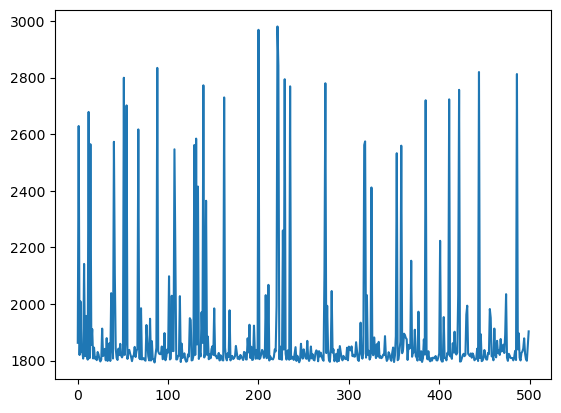

In [100]:
print(loss_data)
plt.plot(loss_data)

In [101]:
print(y1_pred_data[0].shape)
y1_pred_data = np.concatenate(y1_pred_data,axis=0)
print(y1_pred_data.shape)

(1, 12)
(500, 12)


In [102]:
print(y1_ref_data[0].shape)
y1_ref_data = np.concatenate(y1_ref_data,axis=0)
print(y1_ref_data.shape)

(1, 12)
(500, 12)


In [115]:
print(y1_ref_data[0])
print(y1_pred_data[0])

[    0.         0.     32344.332  32344.332      0.         0.
  6573.0083  6573.0083     0.         0.         0.         0.    ]
[-3.5457085e+01 -2.0151760e+01  3.2279092e+04  3.2313355e+04
  4.4702038e+01 -5.5195503e+01  6.6979204e+03  6.7102695e+03
 -6.8598038e+01  1.4261823e+00  3.2566181e+01  5.8492126e+00]


In [104]:
y1_relative_error = np.zeros_like(y1_ref_data)
for i in range(500):
    for j in range(12):
        if y1_ref_data[i,j] <= 0.01:
            y1_relative_error[i,j] = np.abs((y1_ref_data[i,j] - y1_pred_data[i,j]))
        else:
            y1_relative_error[i,j] = np.abs((y1_ref_data[i,j] - y1_pred_data[i,j]) / y1_ref_data[i,j])

print(y1_relative_error.shape)
y1_relative_error[0]

y1_relative_error_mean = 0
for i in range(500):
    y1_relative_error_mean += np.mean(y1_relative_error[i,:])
y1_relative_error_mean /= 500
y1_relative_error_mean

(500, 12)


17.96730895996094

21.999071


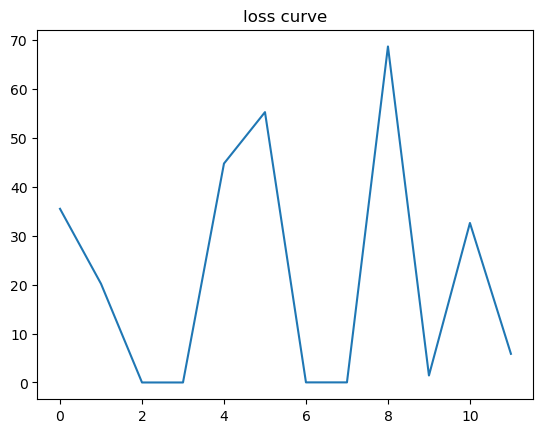

In [105]:
plt.plot(y1_relative_error[0])
plt.title("loss curve")
print(np.mean(y1_relative_error[0]))

In [106]:
print(y2_ref_data[0].shape)
y2_ref_data = np.concatenate(y2_ref_data,axis=0)
print(y2_ref_data.shape)

(1, 8760)
(500, 8760)


In [107]:
print(y2_pred_data[0].shape)
y2_pred_data = np.concatenate(y2_pred_data,axis=0)
print(y2_pred_data.shape)

(1, 8760)
(500, 8760)


In [108]:
y2_relative_error = np.zeros_like(y2_ref_data)
for i in range(500):
    for j in range(8760):
        if y2_ref_data[i,j] <= 0.01:
            y2_relative_error[i,j] = np.abs((y2_ref_data[i,j] - y2_pred_data[i,j]))
        else:
            y2_relative_error[i,j] = np.abs((y2_ref_data[i,j] - y2_pred_data[i,j]) / y2_ref_data[i,j])

print(y2_relative_error.shape)
y2_relative_error[0]

(500, 8760)


array([0.03210872, 0.03081002, 0.02229572, ..., 0.08811194, 0.05728418,
       0.0135528 ], dtype=float32)

0.14177461


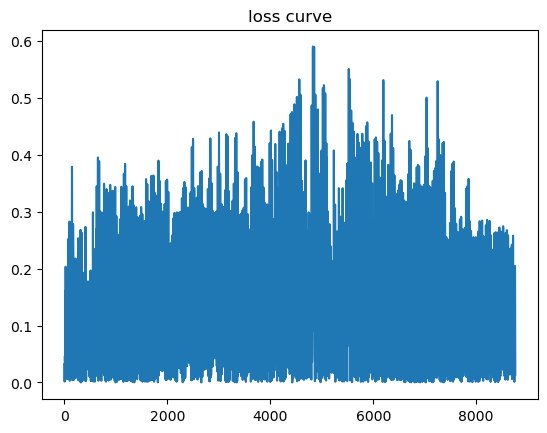

In [109]:
plt.plot(y2_relative_error[0])
plt.title("loss curve")
print(np.mean(y2_relative_error[0]))

In [110]:
y2_relative_error_mean = 0
for i in range(500):
    y2_relative_error_mean += np.mean(y2_relative_error[i,:])
y2_relative_error_mean /= 500
y2_relative_error_mean

0.1388154158592224

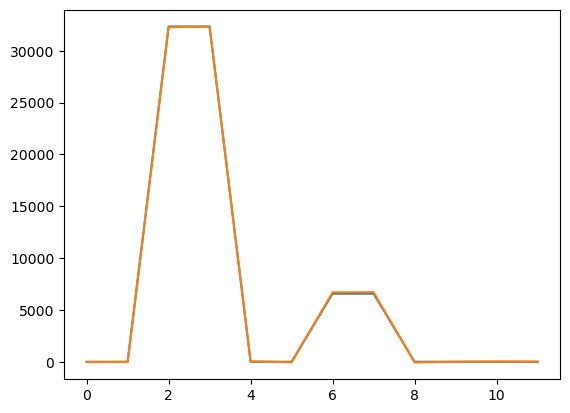

In [113]:
plt.plot(y1_ref_data[0])
plt.plot(y1_pred_data[0])

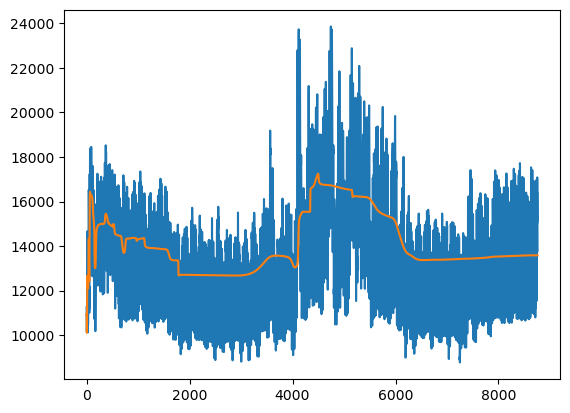

In [114]:
plt.plot(y2_ref_data[0])
plt.plot(y2_pred_data[0])